In [1]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import sys
sys.path.append('/home/mei/nas/docker/thesis/model_train')
from dataloader.ts_reader import MultiModalDataset, collate_fn_pre_train
from model.autoencoder_ts import TimeSeriesAutoencoder, TransformerAutoencoder,LSTMTFAutoencoder,TransformerEncoderDecoder
from pre_train_autoencoder import train_model, test_model, visualize_reconstruction, generate_mask,masked_mae_loss,calculate_correlation

import gc
gc.collect()

import torch
torch.cuda.empty_cache()

In [2]:
train_data_dir = "/home/mei/nas/docker/thesis/data/hdf/train"
val_data_dir = "/home/mei/nas/docker/thesis/data/hdf/val"
test_data_dir = "/home/mei/nas/docker/thesis/data/hdf/test"

lstm_dataset_train = MultiModalDataset(train_data_dir)
lstm_dataset_val = MultiModalDataset(val_data_dir)
lstm_dataset_test = MultiModalDataset(test_data_dir)

lstm_loader_train = DataLoader(lstm_dataset_train, batch_size=32, shuffle=True, collate_fn=collate_fn_pre_train)
lstm_loader_val = DataLoader(lstm_dataset_val, batch_size=32, shuffle=False,collate_fn=collate_fn_pre_train)
lstm_loader_test = DataLoader(lstm_dataset_test, batch_size=32, shuffle=False,collate_fn=collate_fn_pre_train)

In [ ]:
best_config = {
    "input_dim": 324,
    "hidden_dim": 32,
    "lr": 0.0001,
    "epochs": 10,
}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lstm_model = TimeSeriesAutoencoder(
    input_dim=best_config["input_dim"],
    hidden_dim=best_config["hidden_dim"]).to(device)

criterion = nn.L1Loss()
optimizer = optim.Adam(lstm_model.parameters(), lr=best_config["lr"])

In [ ]:
train_model(lstm_model, lstm_loader_train, lstm_loader_val, criterion, optimizer, best_config, device)

In [ ]:
best_model_path = "/home/mei/nas/docker/thesis/data/model/pre_train_autoencoder/best_model_32_1e-4.pth"
lstm_model.load_state_dict(torch.load(best_model_path,weights_only=True))
lstm_model.eval()
test_model(lstm_model, lstm_loader_test, criterion, device)

In [ ]:
visualize_reconstruction(lstm_model, lstm_loader_test, device,feature_indices=[1])

## overfit model

In [3]:
from torch.utils.data import DataLoader, TensorDataset

small_data_iter = iter(lstm_loader_train) 
inputs, lengths = next(small_data_iter)  

small_dataset = TensorDataset(inputs, lengths)
small_train_loader = DataLoader(small_dataset, batch_size=len(inputs), shuffle=True) 

In [5]:
best_config = {
    "input_dim": 324,
    "hidden_dim": 32,
    "lr": 0.0001,
    "epochs": 10,
    "num_layers": 4
}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lstm_model = TimeSeriesAutoencoder(
    input_dim=best_config["input_dim"],
    hidden_dim=best_config["hidden_dim"],   
    num_layers=best_config["num_layers"]).to(device)
optimizer = optim.Adam(lstm_model.parameters(), lr=best_config["lr"])

In [9]:
## hidden state as decoder input
num_epochs = 500  
for epoch in range(num_epochs):
    
    lstm_model.train()
    for batch in small_train_loader:
        inputs, lengths = batch
        inputs = inputs.to(device)
        lengths = lengths.to(device)

        optimizer.zero_grad()

        outputs, _ = lstm_model(inputs, lengths)
        
        mask = generate_mask(inputs.size(1), lengths, device)
        loss = masked_mae_loss(outputs, inputs, mask)
        corr = calculate_correlation(outputs, inputs, mask)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(lstm_model.parameters(), max_norm=1.0)
        optimizer.step()
        
    if (epoch + 1) % 50 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.6f}, Correlation: {corr:.6f}")


Epoch 50/500, Loss: 0.254945, Correlation: 0.097613
Epoch 100/500, Loss: 0.223005, Correlation: 0.297668
Epoch 150/500, Loss: 0.161237, Correlation: 0.576810
Epoch 200/500, Loss: 0.100345, Correlation: 0.742852
Epoch 250/500, Loss: 0.065515, Correlation: 0.825651
Epoch 300/500, Loss: 0.048384, Correlation: 0.862698
Epoch 350/500, Loss: 0.040394, Correlation: 0.876589
Epoch 400/500, Loss: 0.037086, Correlation: 0.883210
Epoch 450/500, Loss: 0.035627, Correlation: 0.886581
Epoch 500/500, Loss: 0.035012, Correlation: 0.888267


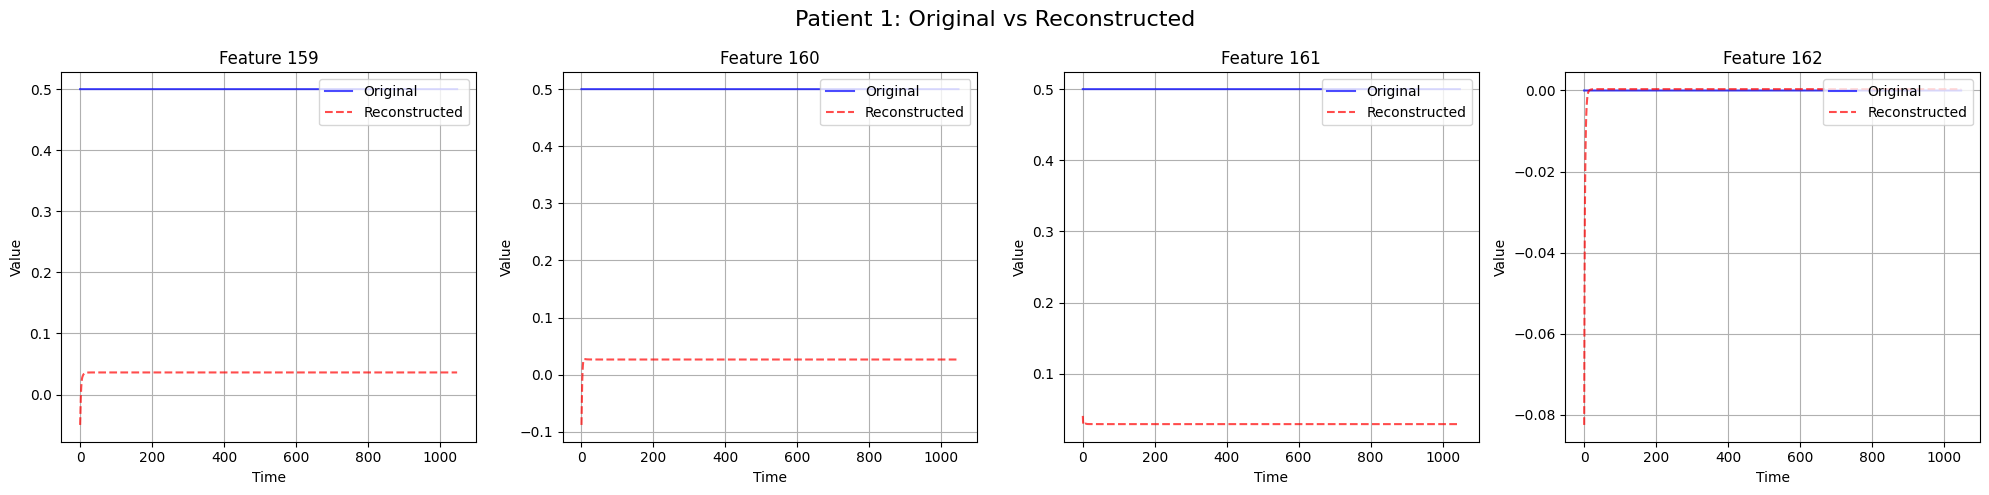

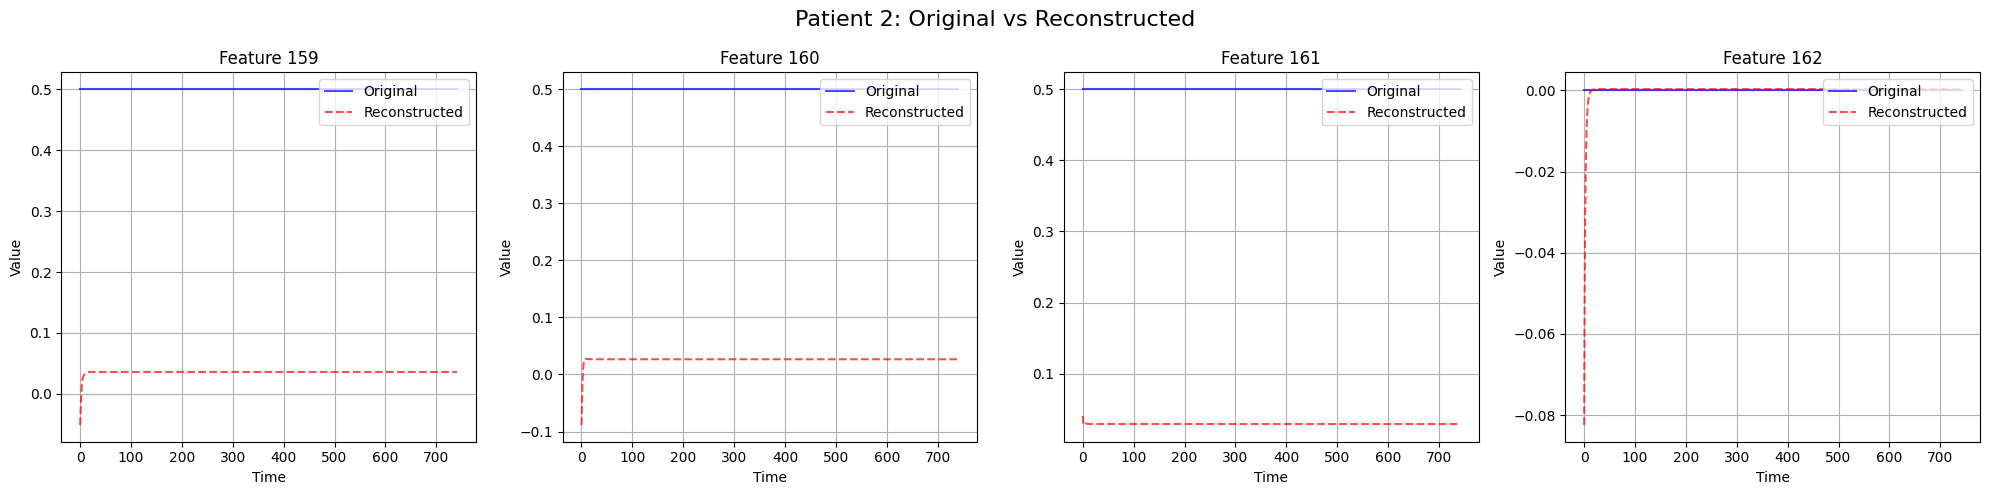

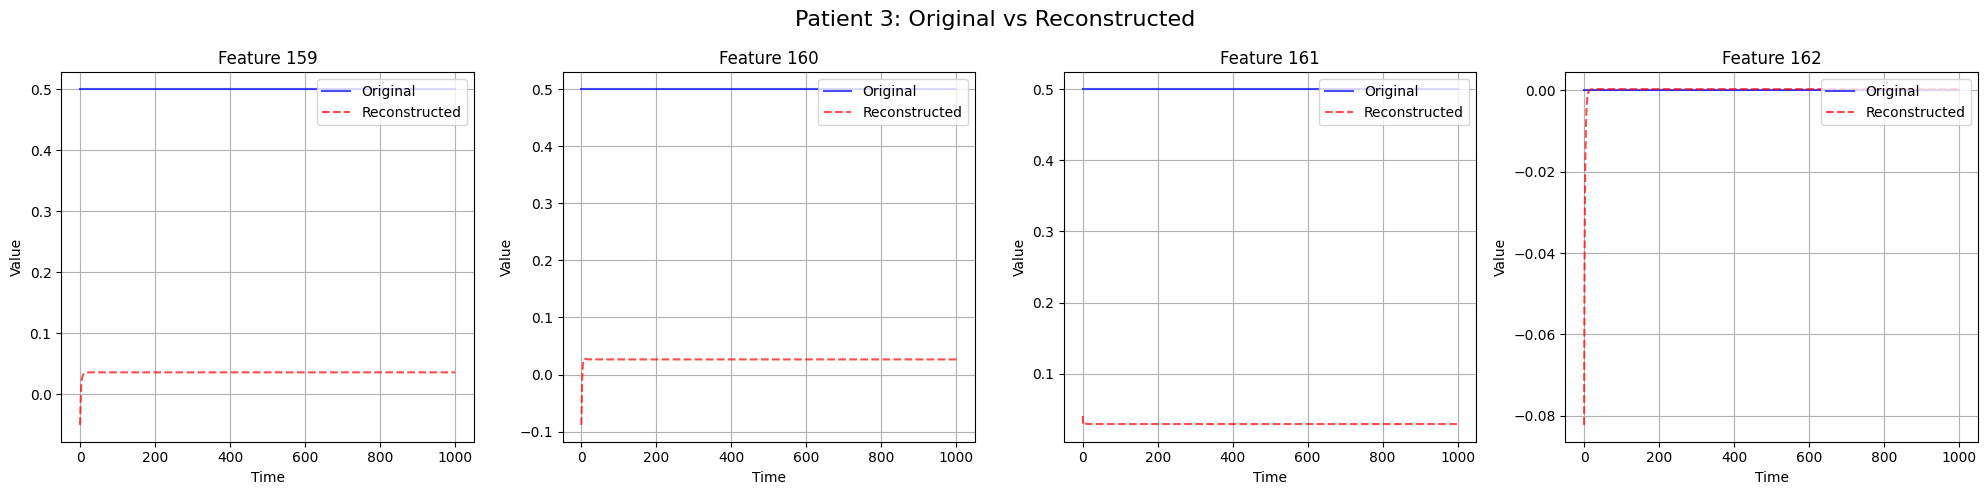

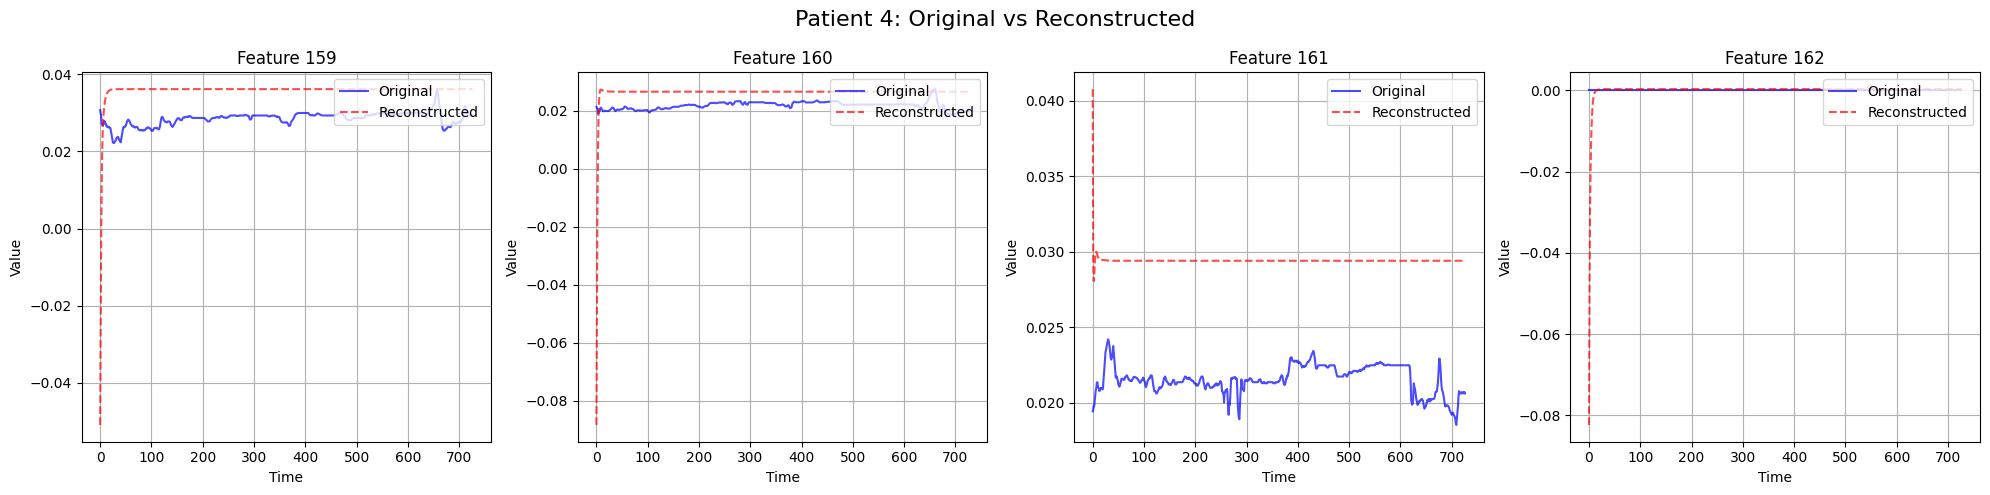

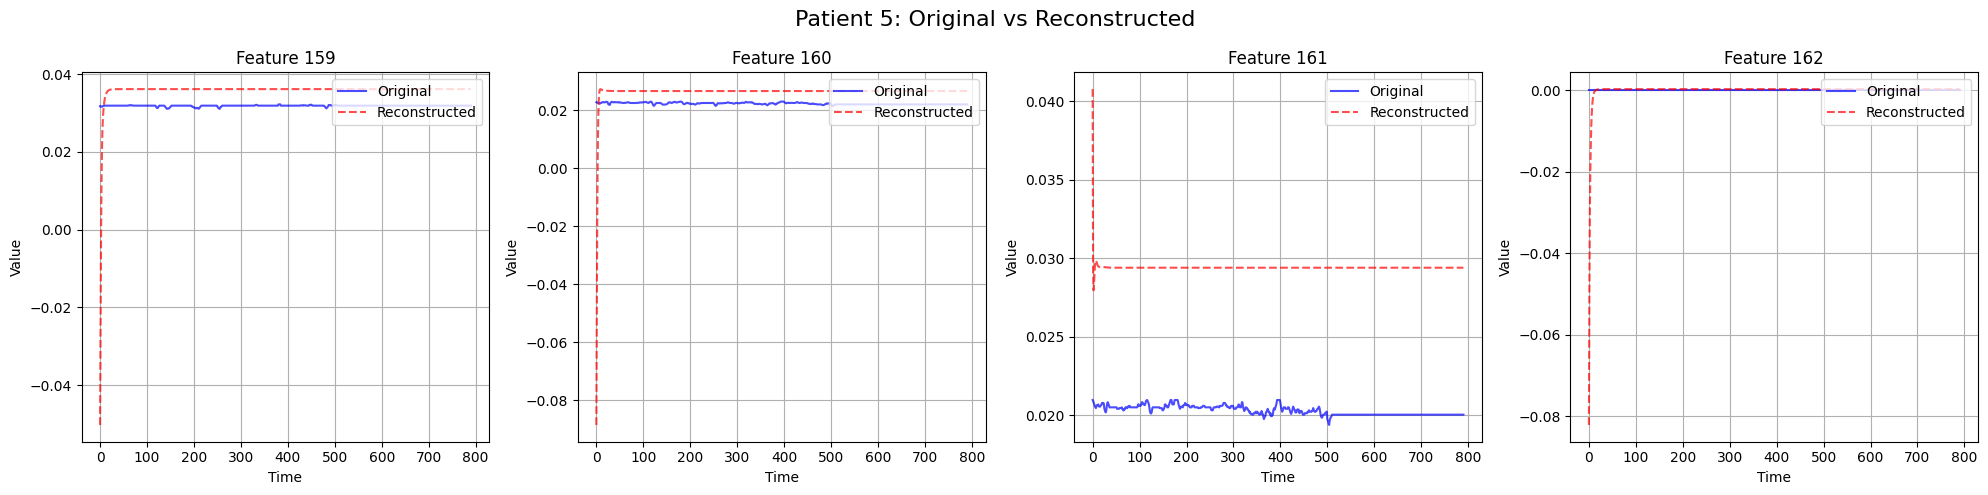

In [10]:
visualize_reconstruction(lstm_model, 
                         small_train_loader, device, num_samples=5,
                         feature_indices=[159,160,161,162])

## transformer autoencoder

In [4]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trans_model = TransformerAutoencoder(input_dim=324, hidden_dim=32, num_heads=4, num_layers=2).to(device)
optimizer = torch.optim.Adam(trans_model.parameters(), lr=0.0001)


In [6]:
num_epochs = 500  
for epoch in range(num_epochs):
    trans_model.train()
    for batch in small_train_loader:
        inputs, lengths = batch
        inputs = inputs.to(device)
        lengths = lengths.to(device)

        optimizer.zero_grad()
        outputs = trans_model(inputs)

        mask = generate_mask(inputs.size(1), lengths,device)
        loss = masked_mae_loss(outputs, inputs, mask)
        corr = calculate_correlation(outputs, inputs, mask)
        torch.nn.utils.clip_grad_norm_(trans_model.parameters(), max_norm=1.0)
        
        loss.backward()
        optimizer.step()
    if (epoch + 1) % 50 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.6f},Correlation: {corr:.6f}")


Epoch 50, Loss: 0.119471,Correlation: 0.806794
Epoch 100, Loss: 0.103570,Correlation: 0.834710
Epoch 150, Loss: 0.095699,Correlation: 0.847735
Epoch 200, Loss: 0.090701,Correlation: 0.855465
Epoch 250, Loss: 0.086640,Correlation: 0.862045
Epoch 300, Loss: 0.082374,Correlation: 0.868630
Epoch 350, Loss: 0.077307,Correlation: 0.877132
Epoch 400, Loss: 0.068540,Correlation: 0.888898
Epoch 450, Loss: 0.056193,Correlation: 0.901778
Epoch 500, Loss: 0.048291,Correlation: 0.907278


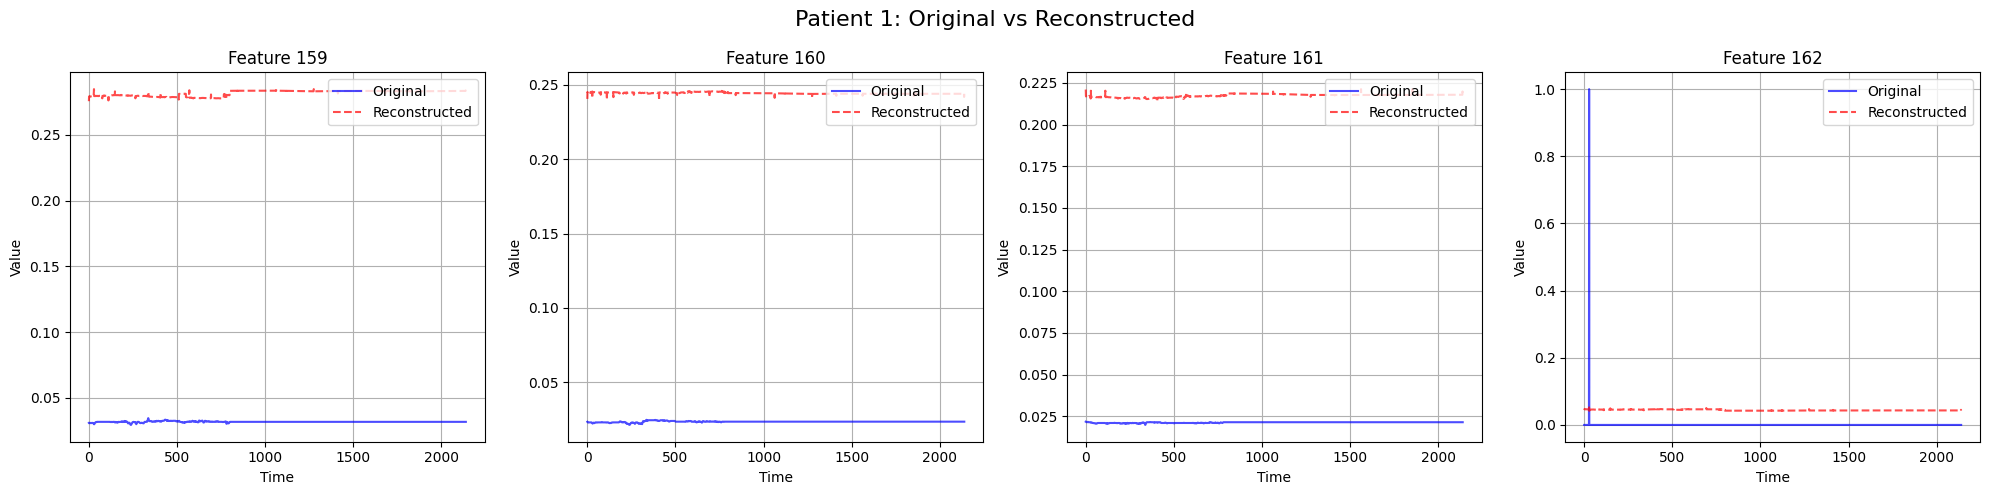

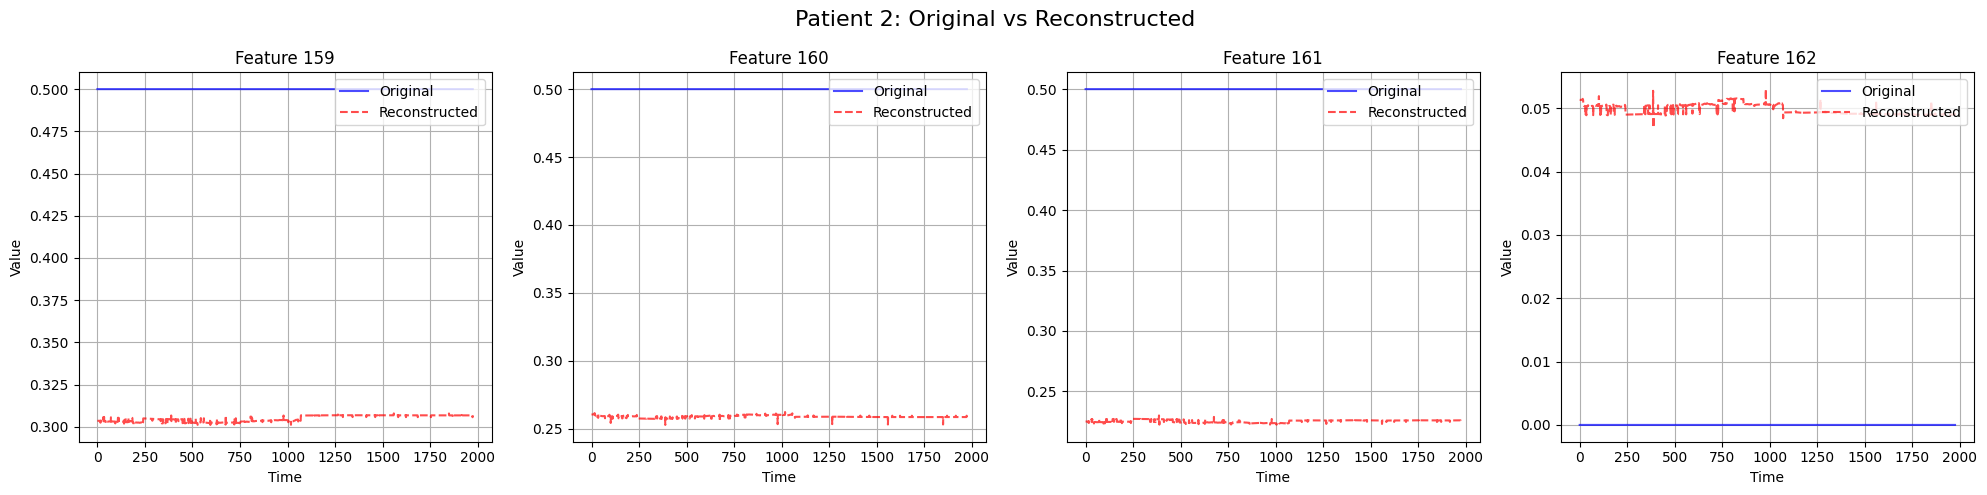

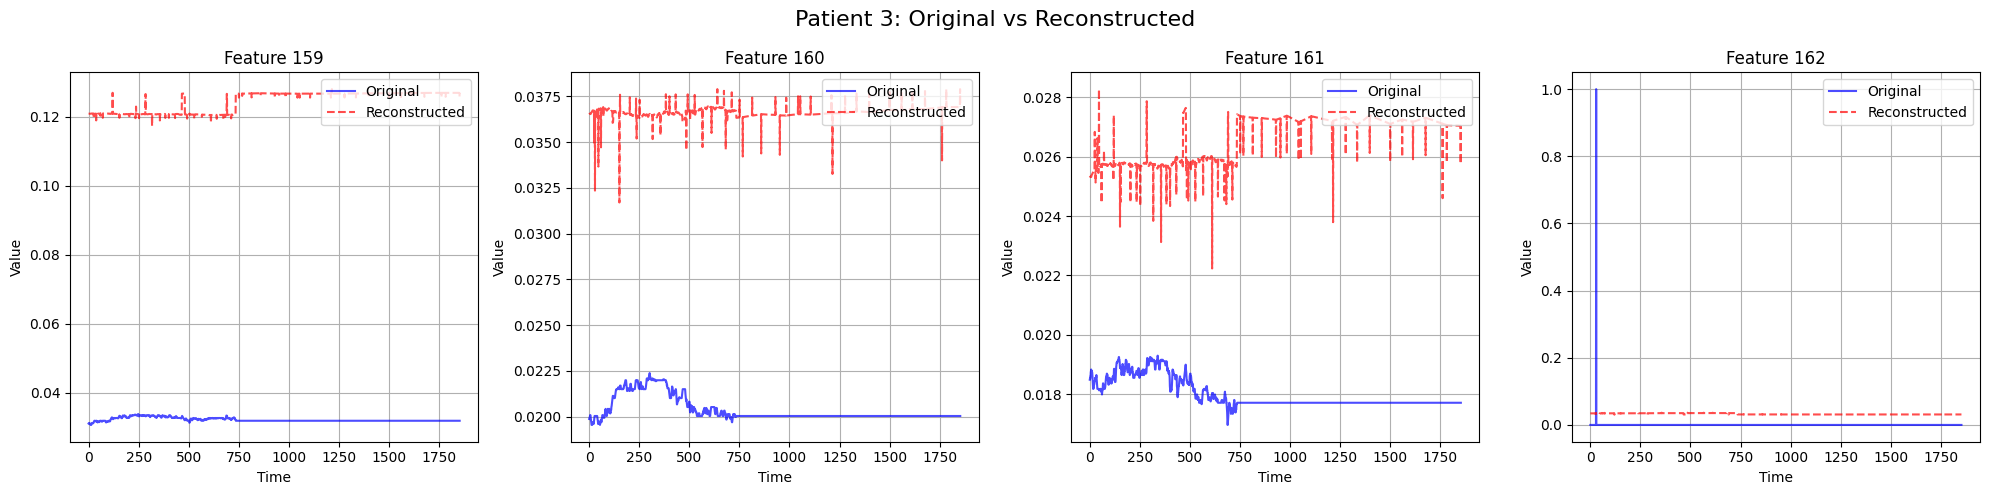

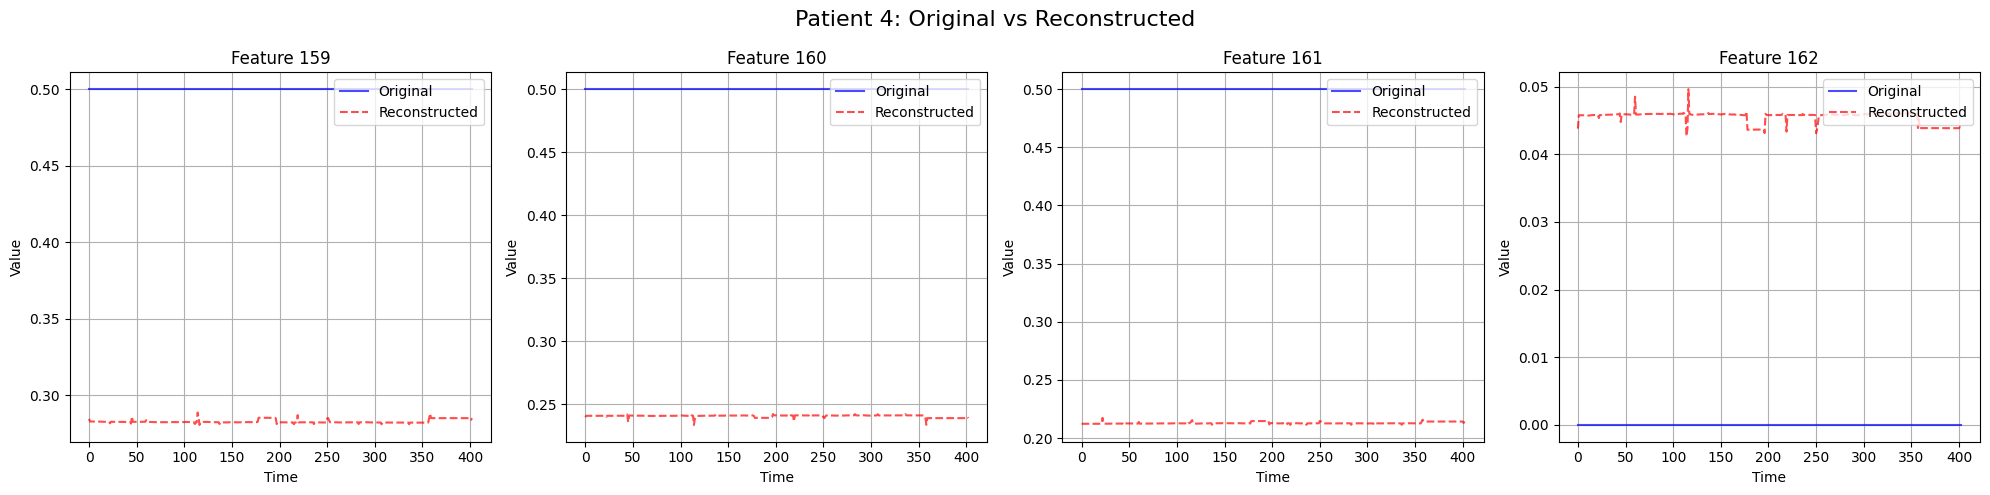

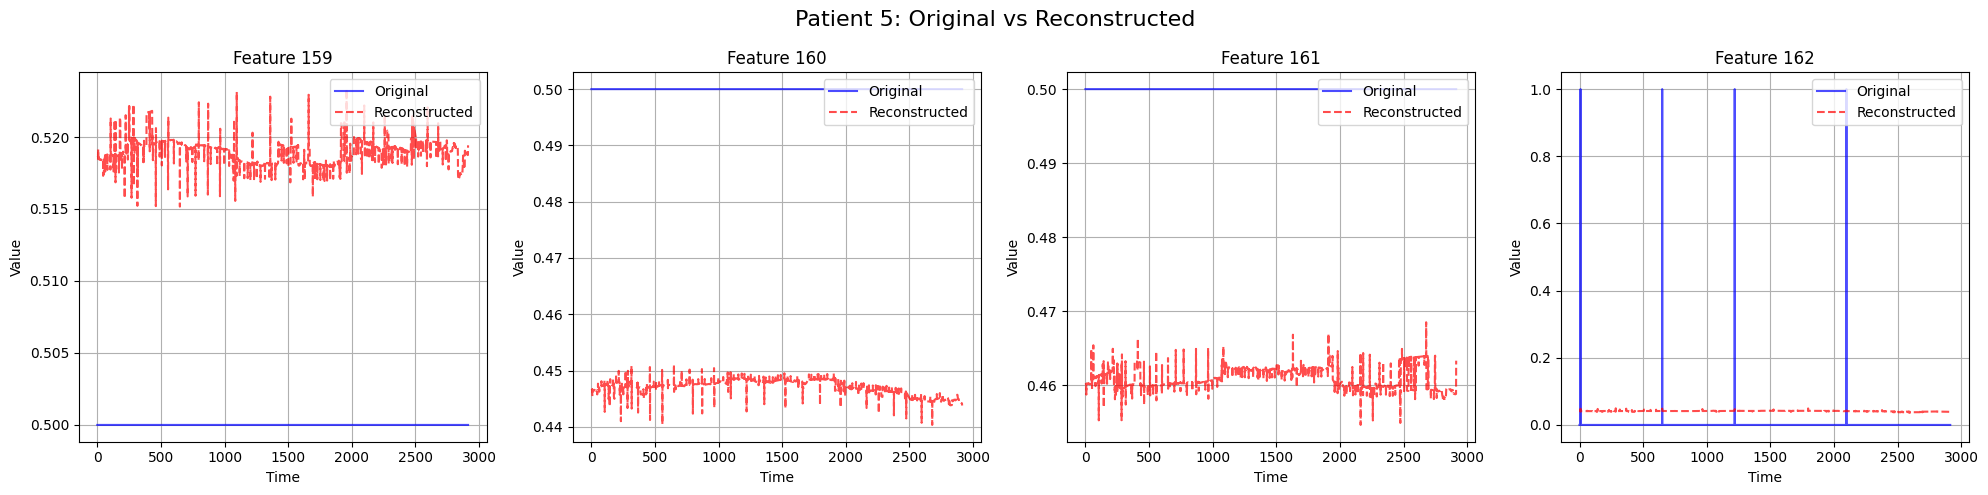

In [10]:
visualize_reconstruction(trans_model, small_train_loader, device, num_samples=5,feature_indices=[159,160,161,162],transformer=True)

## teacher forcing

In [3]:
from torch.utils.data import DataLoader, TensorDataset

small_data_iter = iter(lstm_loader_train) 
inputs, lengths = next(small_data_iter)  

small_dataset = TensorDataset(inputs, lengths)
small_train_loader = DataLoader(small_dataset, batch_size=len(inputs), shuffle=True) 

In [4]:
input_dim = 324
hidden_dim = 32
num_layers = 4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tf_model = LSTMTFAutoencoder(input_dim=input_dim, hidden_dim=hidden_dim, num_layers=num_layers).to(device)
optimizer = torch.optim.Adam(tf_model.parameters(), lr=0.0001)

In [7]:
num_epochs = 500  
for epoch in range(num_epochs):
    
    tf_model.train()
    for batch in small_train_loader:
        inputs, lengths = batch
        inputs = inputs.to(device)
        lengths = lengths.to(device)

        optimizer.zero_grad()
        
        outputs,_ = tf_model(inputs, lengths)
        mask = generate_mask(inputs.size(1), lengths,device)
        loss = masked_mae_loss(outputs, inputs, mask)
        corr = calculate_correlation(outputs, inputs, mask)

        
        torch.nn.utils.clip_grad_norm_(tf_model.parameters(), max_norm=1.0)
        loss.backward()
        optimizer.step()
        
    if (epoch + 1) % 50 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.6f}, Correlation: {corr:.6f}")


Epoch 50/500, Loss: 0.261191, Correlation: 0.035554
Epoch 100/500, Loss: 0.236849, Correlation: 0.169503
Epoch 150/500, Loss: 0.177359, Correlation: 0.448968
Epoch 200/500, Loss: 0.114904, Correlation: 0.642355
Epoch 250/500, Loss: 0.077843, Correlation: 0.757600
Epoch 300/500, Loss: 0.056080, Correlation: 0.824554
Epoch 350/500, Loss: 0.045102, Correlation: 0.860835
Epoch 400/500, Loss: 0.038352, Correlation: 0.880863
Epoch 450/500, Loss: 0.034717, Correlation: 0.890811
Epoch 500/500, Loss: 0.032773, Correlation: 0.895816


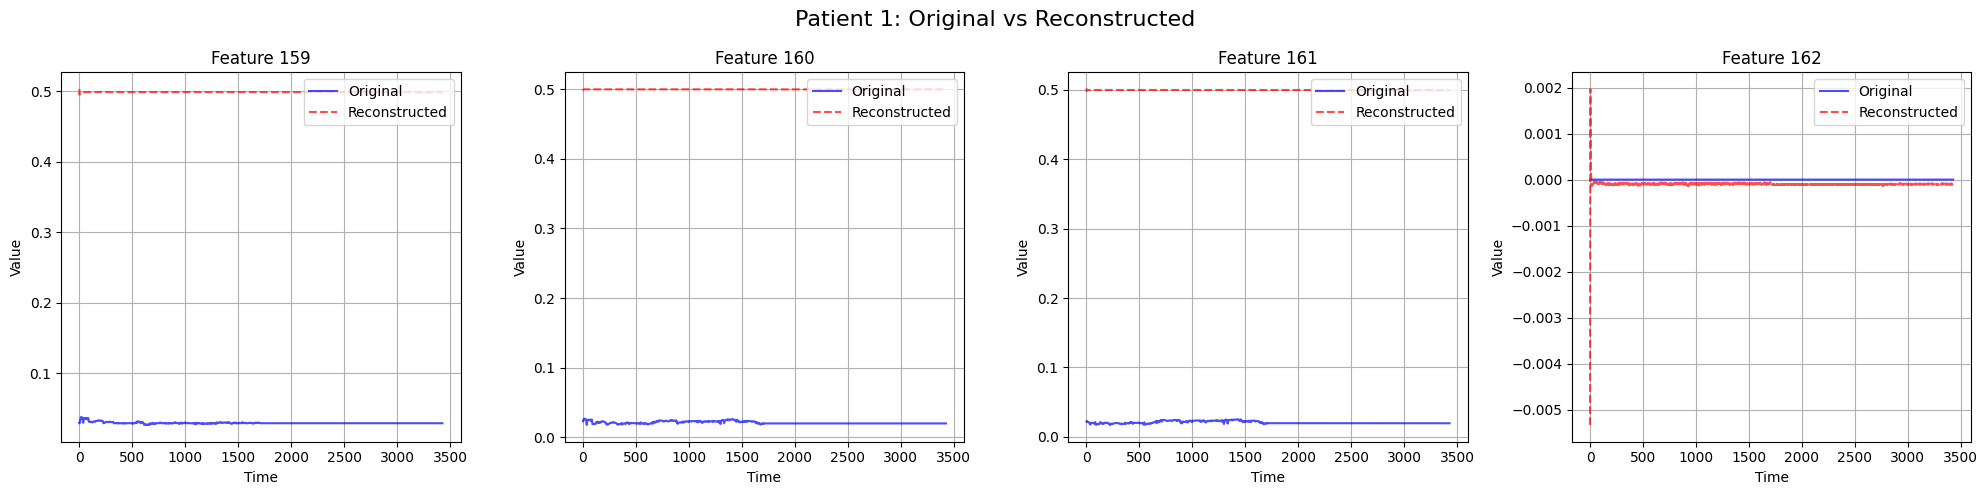

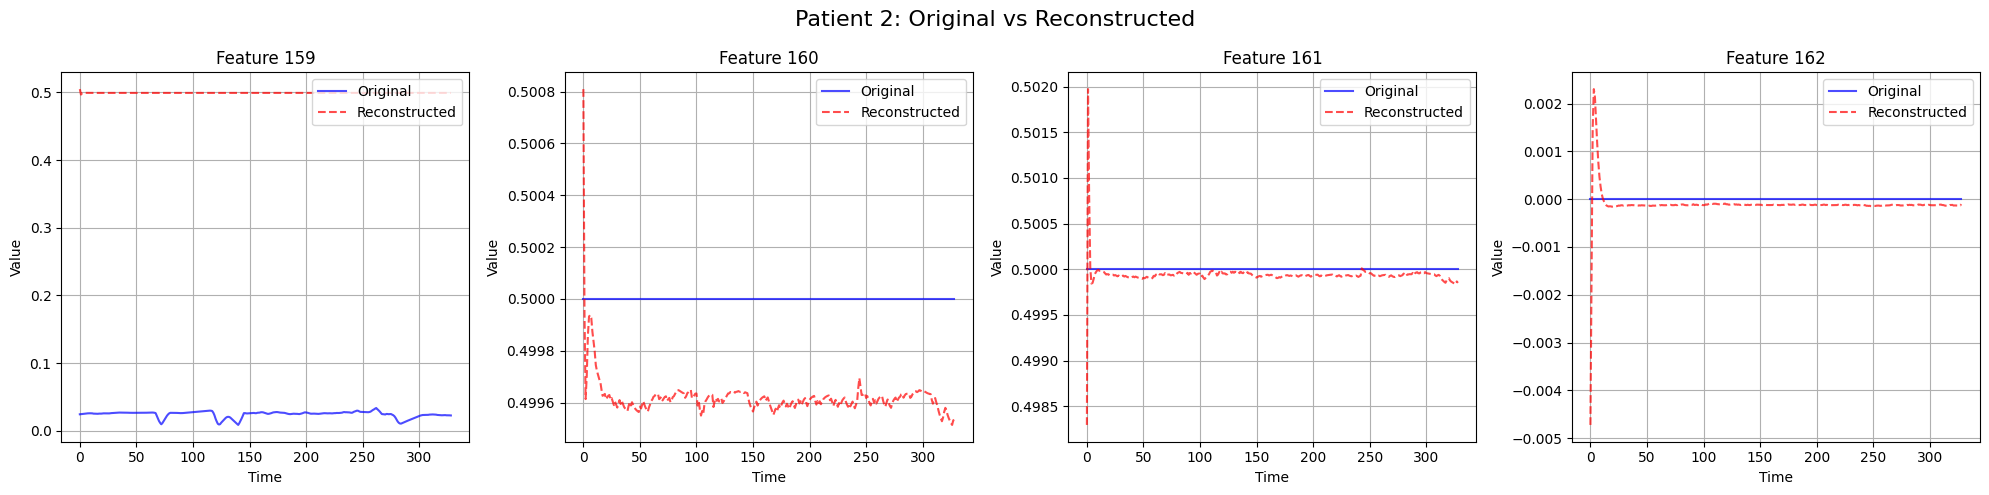

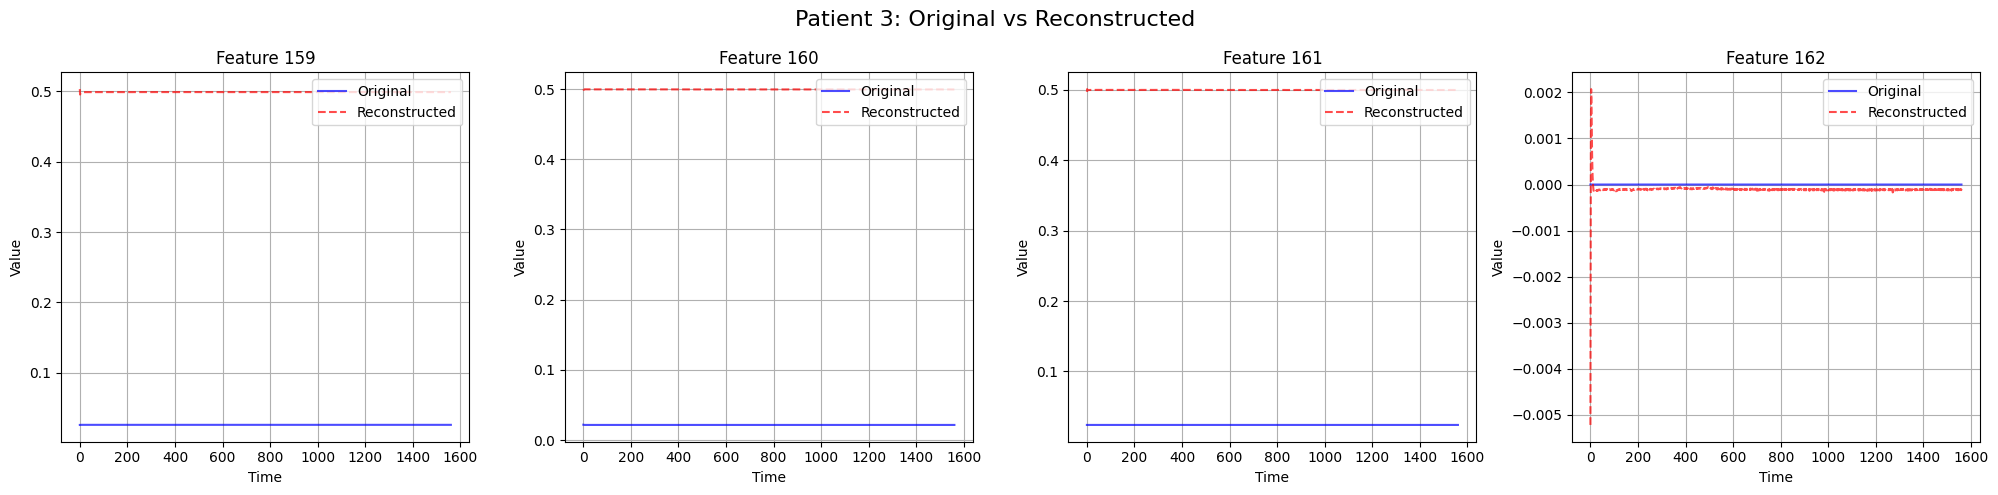

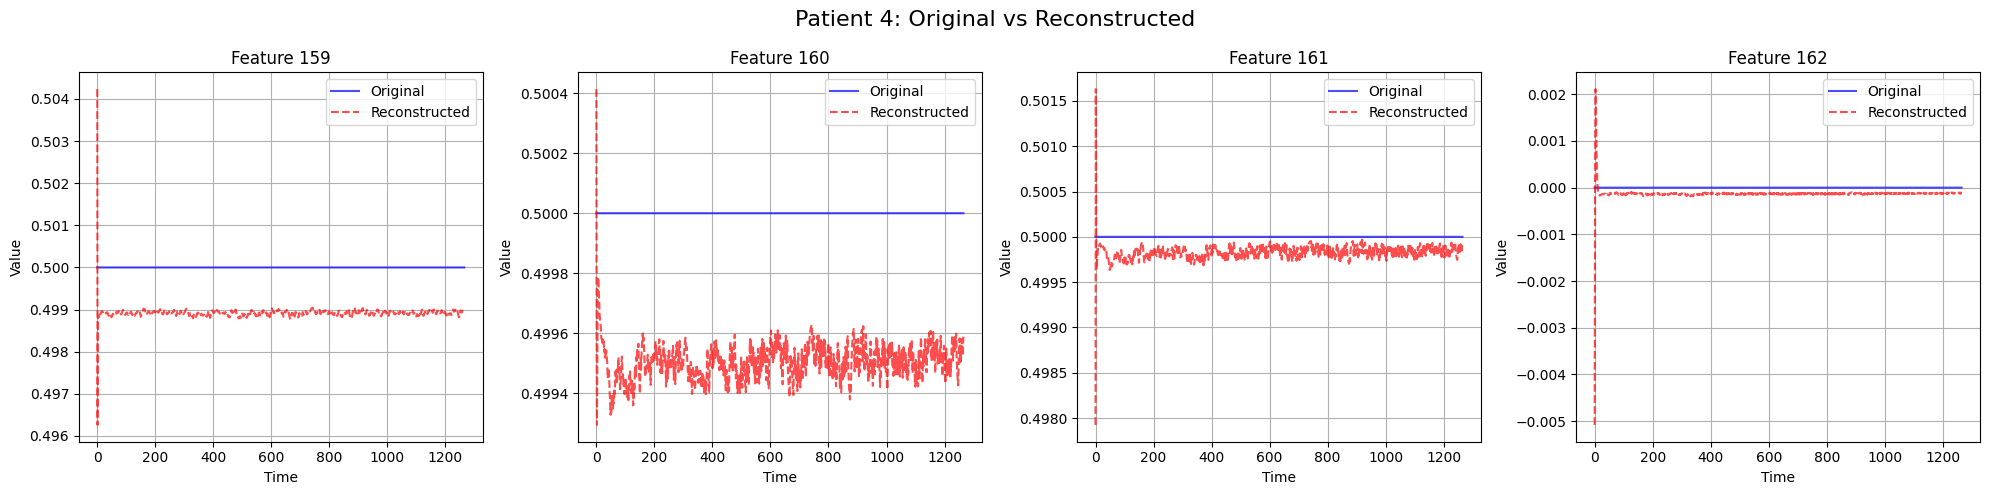

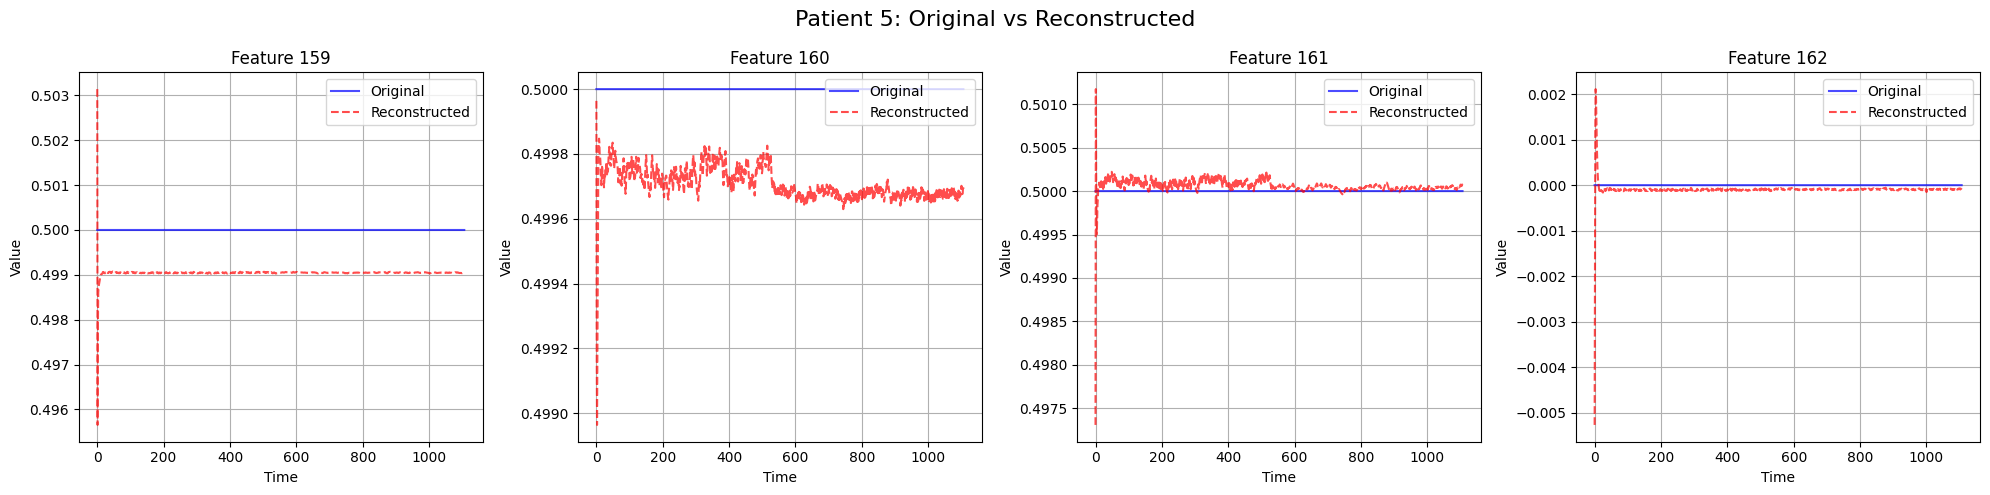

In [8]:
visualize_reconstruction(tf_model, small_train_loader, device, num_samples=5,feature_indices=[159,160,161,162],transformer=False)

## transformer as encoder decoder model

In [3]:
from torch.utils.data import DataLoader, TensorDataset

small_data_iter = iter(lstm_loader_train) 
inputs, lengths = next(small_data_iter)  

small_dataset = TensorDataset(inputs, lengths)
small_train_loader = DataLoader(small_dataset, batch_size=len(inputs), shuffle=True) 

In [5]:
input_dim = 324 
d_model = 32    
nhead = 4       
num_encoder_layers = 3  
num_decoder_layers = 3 
dim_feedforward = 32   
dropout = 0.1          

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TransformerEncoderDecoder(input_dim, d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, dropout).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [6]:
num_epochs = 500  
for epoch in range(num_epochs):
    
    model.train()
    for batch in small_train_loader:
        inputs, lengths = batch
        inputs = inputs.to(device)
        lengths = lengths.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        mask = generate_mask(inputs.size(1), lengths,device)
        loss = masked_mae_loss(outputs, inputs, mask)
        corr = calculate_correlation(outputs, inputs, mask)
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        loss.backward()
        optimizer.step()
        
    if (epoch + 1) % 50 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.6f}, Correlation: {corr:.6f}")


Epoch 50/500, Loss: 0.352634, Correlation: 0.215954
Epoch 100/500, Loss: 0.247950, Correlation: 0.375289
Epoch 150/500, Loss: 0.174980, Correlation: 0.543108
Epoch 200/500, Loss: 0.130801, Correlation: 0.684262
Epoch 250/500, Loss: 0.104713, Correlation: 0.778495
Epoch 300/500, Loss: 0.088789, Correlation: 0.831606
Epoch 350/500, Loss: 0.079579, Correlation: 0.856935
Epoch 400/500, Loss: 0.074413, Correlation: 0.868811
Epoch 450/500, Loss: 0.071105, Correlation: 0.874260
Epoch 500/500, Loss: 0.068462, Correlation: 0.877546


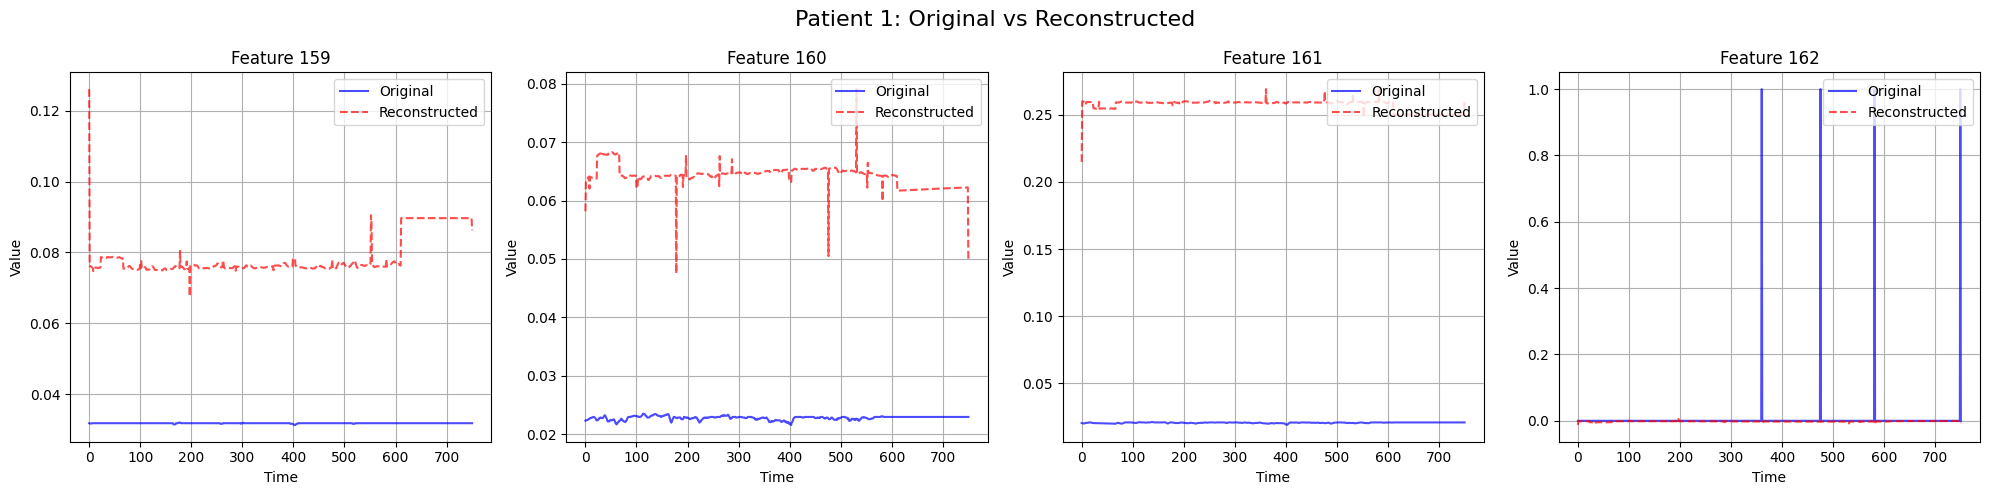

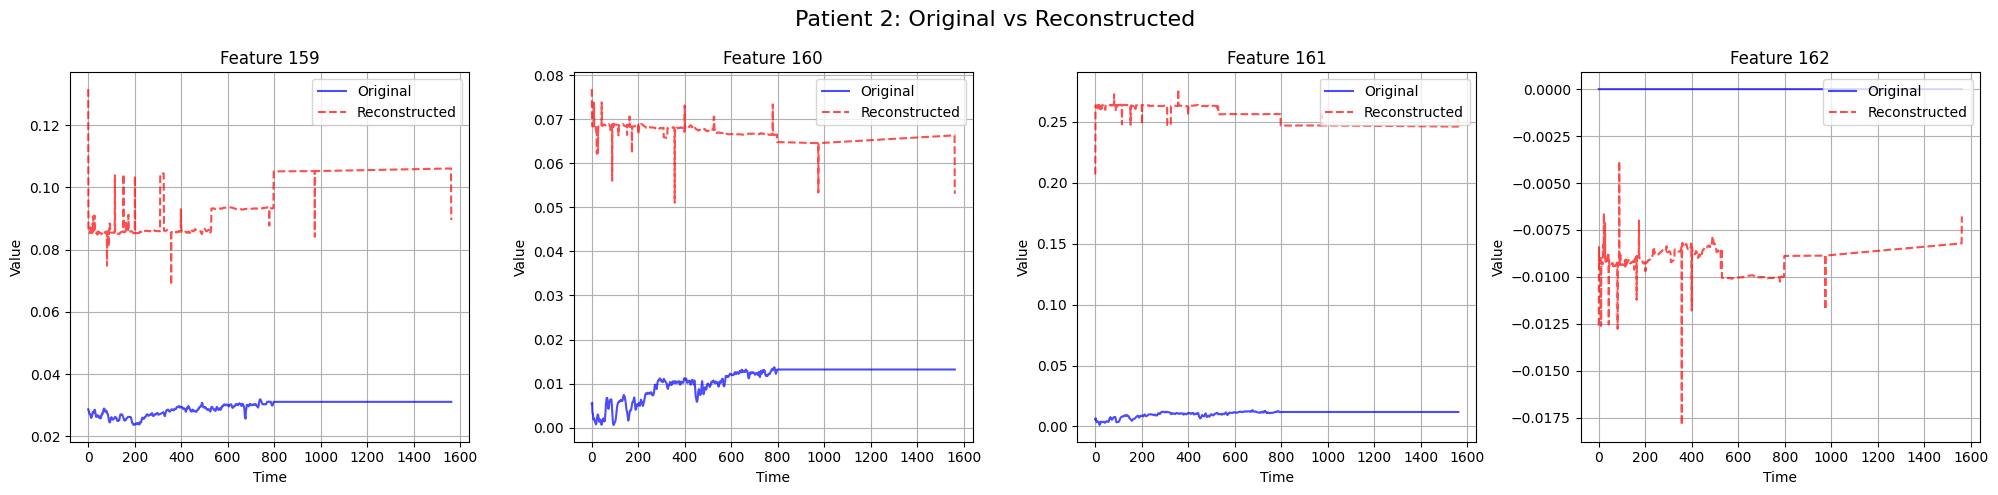

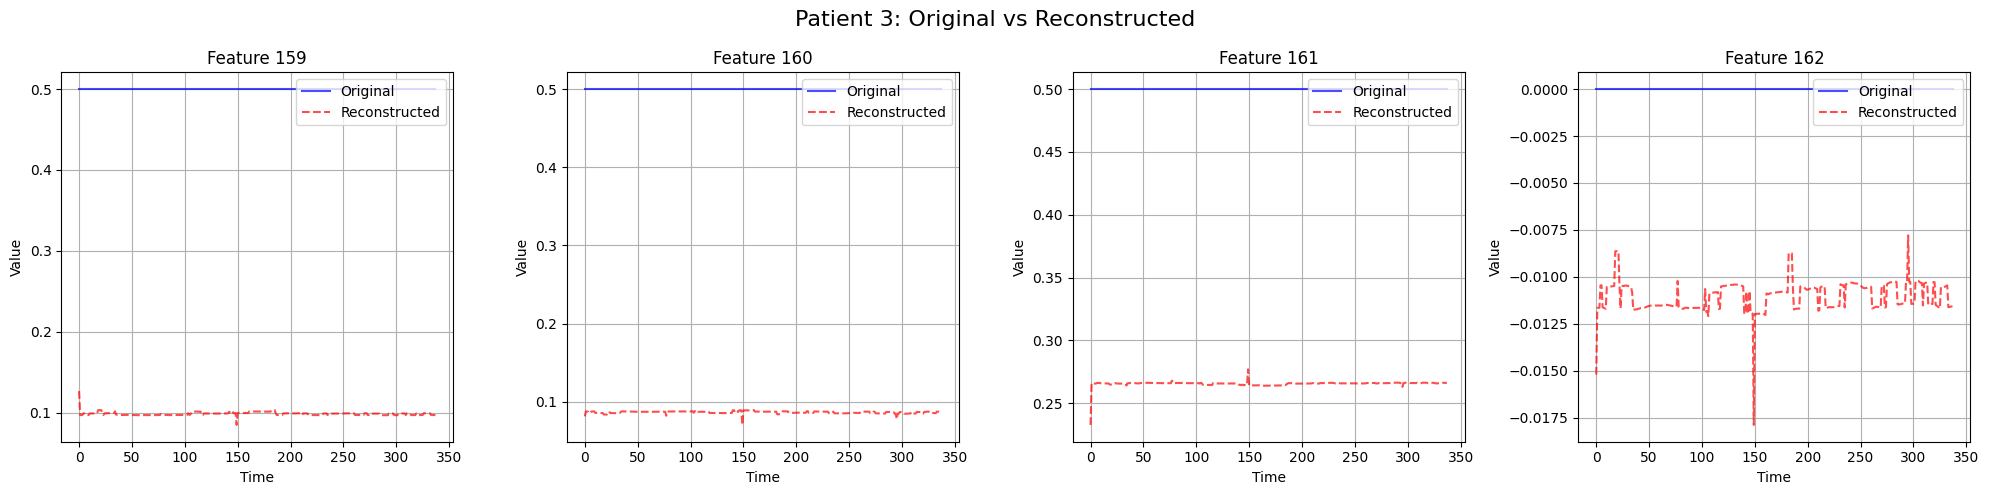

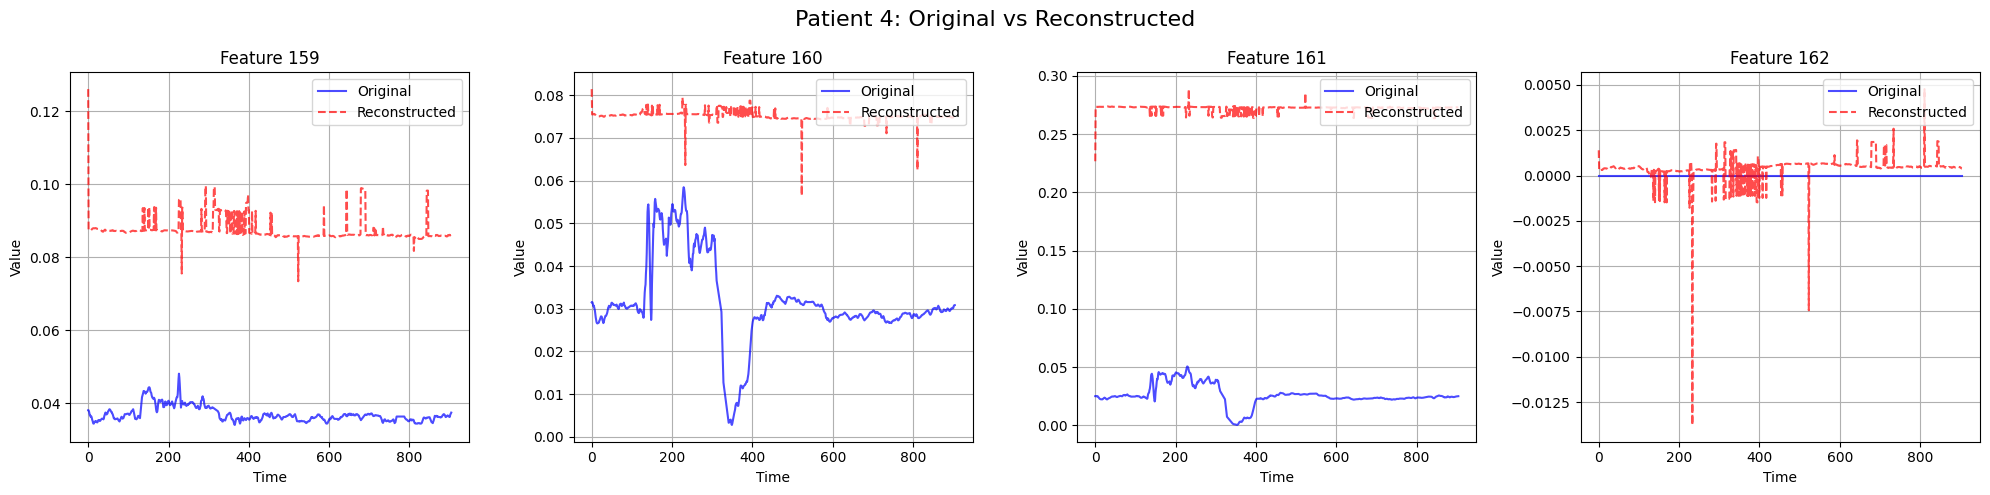

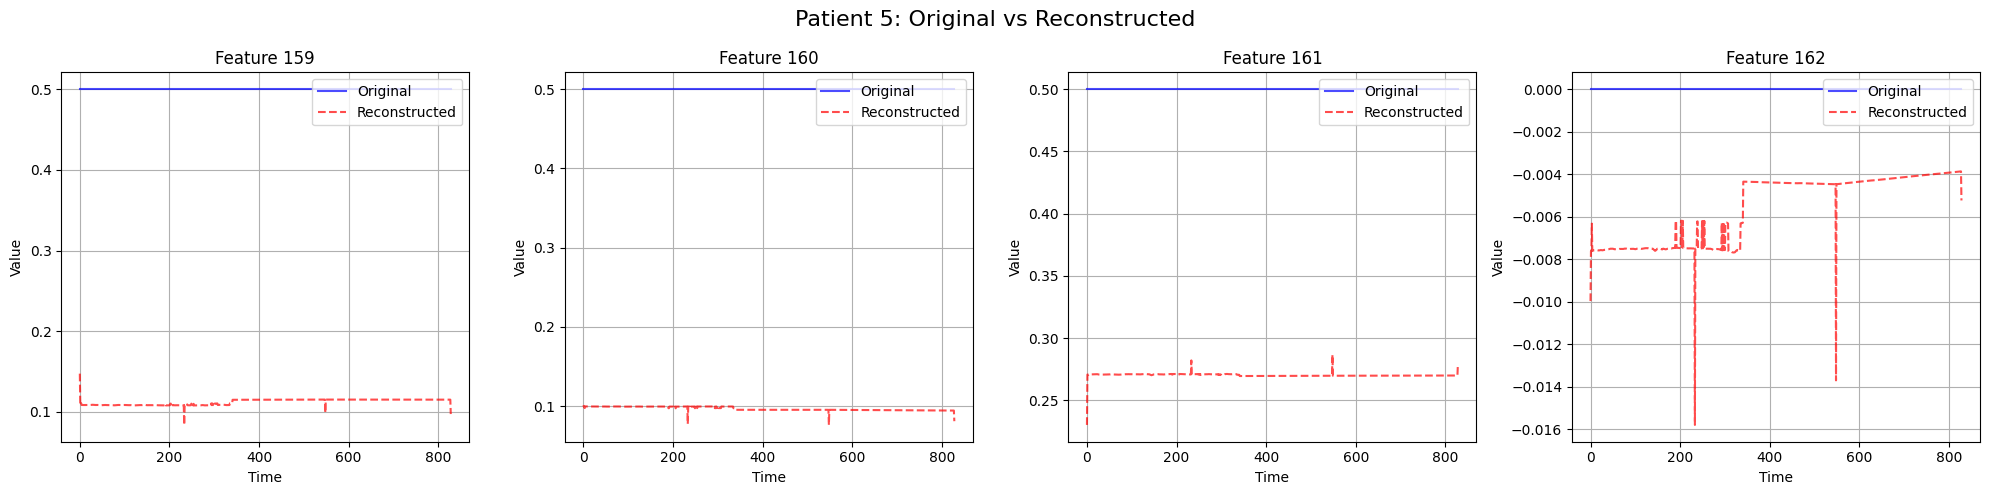

In [7]:
visualize_reconstruction(model, small_train_loader, device, num_samples=5,feature_indices=[159,160,161,162],transformer=True)